In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig
from sklearn.decomposition import PCA
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import LocallyLinearEmbedding, trustworthiness
from sklearn.preprocessing import StandardScaler
import collections

### Functions

In [2]:
def mds_reduction(data, target_dimension):
  return pd.DataFrame(MDS(n_components=target_dimension,eps=1e-4,n_init=15).fit_transform(data))

def get_reduced(X, target_dimension, reduction_type):
  X_transformed = []
  if reduction_type == 'iso':
    embedding = Isomap(n_components=target_dimension, n_neighbors=10)
    X_transformed = embedding.fit_transform(X)
  elif reduction_type == 'pca':
    transformer = PCA(n_components=target_dimension)
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'k-pca':
    transformer = KernelPCA(n_components=target_dimension, kernel='rbf')
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'tsne':
    X_transformed = TSNE(n_components=target_dimension, learning_rate='auto', init='pca').fit_transform(X)
  elif reduction_type == 'mds':
    X_transformed = mds_reduction(X,target_dimension)
  elif reduction_type == 'LLE':
    X_transformed = LocallyLinearEmbedding(n_components=target_dimension, n_neighbors=30).fit_transform(X)
  return X_transformed

def get_cluster(X, num_cluster, cluster_type):
  labels = None
  if cluster_type == 'GMM':
    model = mixture.GaussianMixture(n_components=num_cluster, covariance_type='full', n_init=100)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'k-means':
    model=KMeans(n_clusters=num_cluster, n_init=10, max_iter=10000)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'HS':
    model = AgglomerativeClustering(n_clusters=num_cluster, linkage='single')
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'H':
    model = AgglomerativeClustering(n_clusters=num_cluster)
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'spectral':
    model = SpectralClustering(assign_labels='discretize', n_clusters=num_cluster, random_state=77, n_init=5)
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'custom':
    td = 2
    p = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=20).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  elif cluster_type == 'custom2d':
    td = 2
    p = pd.DataFrame(Isomap(n_components=td, n_neighbors=20).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  elif cluster_type == 'custom50':
    td = 2
    p = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=50).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  return labels

# Epsilon for DBSCAN
def show_distance_graph(X):
  neigh = NearestNeighbors(n_neighbors=2)
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors(X)
  # Plotting K-distance Graph
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  print(distances[-60:])
  plt.figure(figsize=(10,5))
  plt.plot(distances)
  plt.title('K-distance Graph',fontsize=20)
  plt.xlabel('Data Points sorted by distance',fontsize=14)
  plt.ylabel('Epsilon',fontsize=14)
  plt.show()
  #Visualization in 4D

def visualize_4d(frame, hot=True):
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111, projection='3d')
  x = np.array(frame.iloc[:,0])
  if len(frame.columns) > 1:
    y = np.array(frame.iloc[:,1])
  if len(frame.columns) > 2:
    z = np.array(frame.iloc[:,2])
  if len(frame.columns) == 1:
    img = ax.scatter(x, x, s=2)
  if len(frame.columns) == 2:
    img = ax.scatter(x, y, s=2)
  elif len(frame.columns) == 3:
    img = ax.scatter(x, y, z, s=2)
  else:
    c = np.array(frame.iloc[:,3])
    if hot:
      img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), s=2)
    else:
      img = ax.scatter(x, y, z, c=c, cmap='viridis', s=2)
  plt.show()

def merge(X, col, val_list):
  def get_col(row):
    for ind in range(len(val_list)):
      if row[col] in val_list[ind]:
        return 100 + ind
    return row[col]
  X[col] = X.apply(get_col, axis=1)
  X[col] = LabelEncoder().fit_transform(X[col])
  return X

def get_local_intrinsic_dimension(data, n_neighbors=5):
  X = np.array(data)
  M = np.matrix(X)
  L = n_neighbors
  if not isinstance(L, (int, np.integer))  or L<0:
    return 'n_neighbors must be a positive integer!'
  n = len(X)
  neigh = NearestNeighbors(n_neighbors=L)
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors()
  mean = [np.mean([M[indices[i][j]] for j in range(L)],axis=0) for i in range(n)]
  #Calculating the local covariance matrix for each point
  C = [1/L * sum([np.dot( (M[indices[i][j],:]-mean[i]).transpose() , (M[indices[i][j],:]-mean[i]) ) for j in range(L)]) for i in range(n)]

  #Intrinsic Dimension Estimation
  THRESHOLD = 0.05
  intrinsic_dimension = [0] * n

  E = [sorted(eig(C[i])[0], reverse=True) for i in range(n)]
  for i in range(n):
    eigen_list = E[i]
    d = len(eigen_list)
    first_eigenvalue= eigen_list[0]
    for j in range(1,d):
      if eigen_list[j]/first_eigenvalue < THRESHOLD:
        intrinsic_dimension[i]=j
        break
    if intrinsic_dimension[i]==0:
      intrinsic_dimension[i]=d
  return np.array(intrinsic_dimension)

### Open Input

In [3]:
# Input
file = open('./R34.txt','r')
d, n, m, k, p = list(map(int, file.readline().split()))
k_list = list(map(int, file.readline().split()))
ar = []
for i in range(n):
  ar.append(list(map(float, file.readline().split())))
df = pd.DataFrame(ar)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000,47445.000000
mean,395.116165,18.798136,11.767086,65.333210,53.671329,-14.658355,90.384848,45.807652,-42.497517,-75.397516,38.251064,87.976411,-22.434302,-23.339140,-19.281655,-12.180421,-8.620276,63.616985,-57.582718,-37.993690
std,266.811784,24.935348,45.550695,40.146352,39.461867,54.629644,52.542212,38.843944,57.010051,56.718104,38.225065,58.599530,44.895676,43.663445,49.605719,42.325571,46.444426,41.890042,56.523118,44.794546
min,-74.330676,-48.247086,-107.017541,-72.554867,-88.532698,-210.398069,-48.699347,-46.103809,-183.311723,-207.736956,-95.673559,-65.243021,-155.021660,-110.289929,-164.480318,-167.217074,-112.600866,-76.685518,-177.529343,-131.432271
25%,142.696614,4.346738,-17.826894,40.869780,34.074459,-44.509719,51.603034,14.807237,-74.554444,-104.039135,11.931153,50.380686,-54.096187,-54.695319,-57.976636,-41.802191,-46.990609,35.647868,-103.353578,-71.087016
50%,453.130537,16.138345,1.577686,73.112174,57.567301,-12.201728,91.655363,45.349593,-35.594306,-75.996939,42.846283,89.833529,-29.049042,-33.060048,-20.111910,-9.810392,-9.495505,68.426845,-60.361778,-43.810731
75%,605.805961,33.883638,42.400684,95.023733,79.756619,26.269399,130.150962,68.235113,-12.471540,-43.668235,62.957457,131.774980,4.604196,-3.974090,16.200621,20.647906,28.323982,94.568633,-15.385488,-5.041154
max,825.925493,96.910277,124.068918,152.998313,164.139844,126.467441,218.149954,144.643258,121.212037,81.231713,148.945844,256.337931,97.343550,174.513669,100.028103,76.069810,109.735377,166.519424,105.177779,88.988643


### Finding Submanifolds

In [4]:
#DBSCAN
%matplotlib notebook
EPS = 1
MIN_SAMPLES = 6
model_name = 'dbscan'
res = pd.DataFrame(StandardScaler(with_mean=False).fit_transform(df), columns=[i for i in range(d)])
res.describe()
model = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
model.fit(res[[i for i in range(0,d)]])
df['manifold'] = model.labels_
res['manifold'] = model.labels_
print(df['manifold'].describe())
visualize_4d(df[[0,1,2,'manifold']], hot=False)

count    47445.000000
mean         8.330235
std          4.546159
min          0.000000
25%          5.000000
50%          8.000000
75%         12.000000
max         16.000000
Name: manifold, dtype: float64


<IPython.core.display.Javascript object>

In [5]:
def is_manifold(data, dim, n_neighbors=5, error=0.05):
  # Assuming data is consisted of submanifolds with DIFFERENT dimensions OR is just consisted of one manifold
  ID = get_local_intrinsic_dimension(data, n_neighbors=n_neighbors)
  total = len(ID)
  counter = collections.Counter(ID)
  accuracy = counter[dim] / total
  if accuracy > 1 - error:
    # print(f'Accuracy: {accuracy}. Data resides on a {dimension}-dimensional manifold!')
    return accuracy
  # print(f'Accuracy: {accuracy} -> Inconclusive!')
  return accuracy

p = []
# Deciding which two of 1D subsets should be merged
for i in range(df.manifold.max() + 1):
  for j in range(df.manifold.max() + 1):
    v = is_manifold(df[(df['manifold'] == i) | (df['manifold'] == j)][[z for z in range(d)]], dim=1)
    if i != j:
      p.append((v, (i, j)))
    print(round(v, 3), end=' ')
  print()
p = sorted(p, reverse=True)
print(p)

0.614 0.748 0.741 0.713 0.601 0.595 0.197 0.128 0.692 0.243 0.664 0.201 0.416 0.366 0.197 0.198 0.687 
0.748 0.792 0.797 0.769 0.694 0.69 0.43 0.296 0.756 0.46 0.736 0.43 0.571 0.541 0.43 0.431 0.753 
0.741 0.797 0.805 0.769 0.679 0.674 0.357 0.233 0.754 0.393 0.73 0.358 0.529 0.491 0.357 0.358 0.749 
0.713 0.769 0.769 0.745 0.671 0.667 0.406 0.28 0.733 0.436 0.713 0.407 0.547 0.517 0.406 0.407 0.729 
0.601 0.694 0.679 0.671 0.597 0.592 0.331 0.231 0.657 0.361 0.639 0.332 0.473 0.441 0.331 0.331 0.653 
0.595 0.69 0.674 0.667 0.592 0.588 0.326 0.228 0.652 0.356 0.635 0.328 0.469 0.437 0.326 0.327 0.649 
0.197 0.43 0.357 0.406 0.331 0.326 0.053 0.049 0.386 0.084 0.374 0.057 0.205 0.168 0.053 0.054 0.384 
0.128 0.296 0.233 0.28 0.231 0.228 0.049 0.048 0.266 0.069 0.259 0.052 0.149 0.124 0.05 0.05 0.264 
0.692 0.756 0.754 0.733 0.657 0.652 0.386 0.266 0.719 0.417 0.7 0.387 0.531 0.499 0.386 0.387 0.716 
0.243 0.46 0.393 0.436 0.361 0.356 0.084 0.069 0.417 0.114 0.404 0.087 0.235 0.198 0.08

0


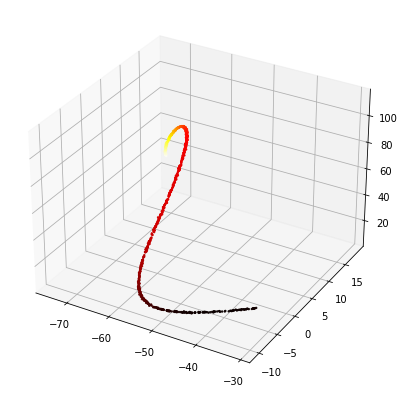

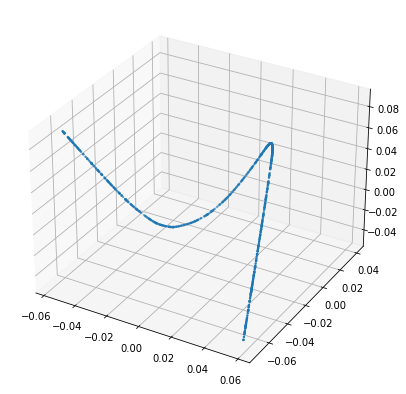

1


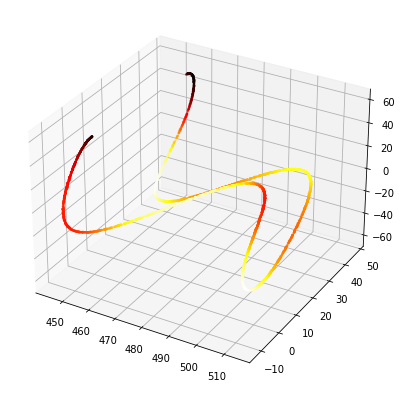

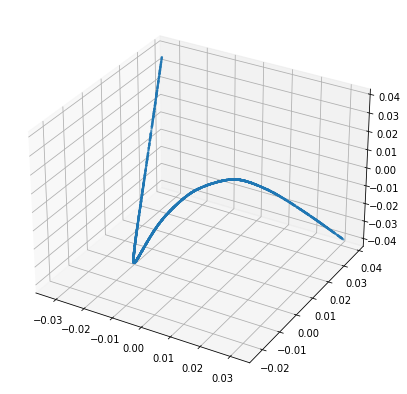

2


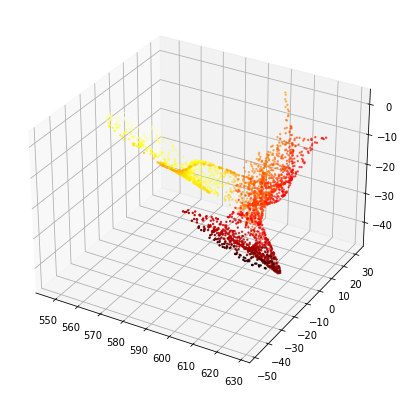

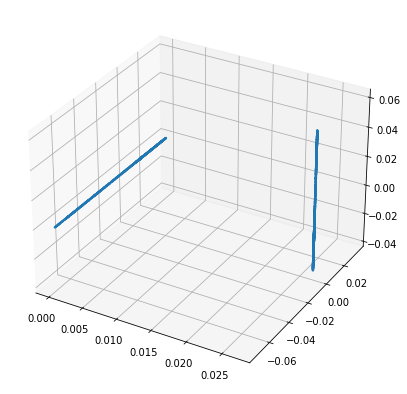

3


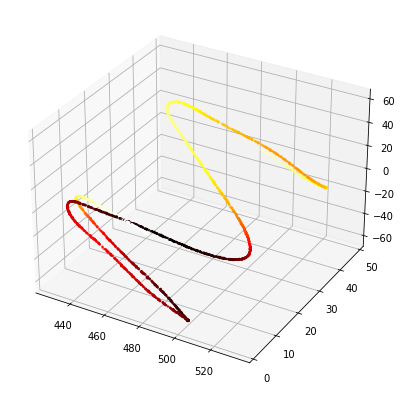

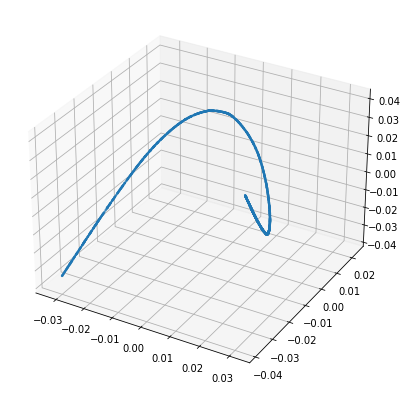

4


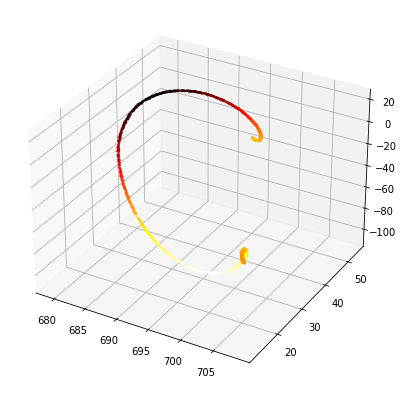

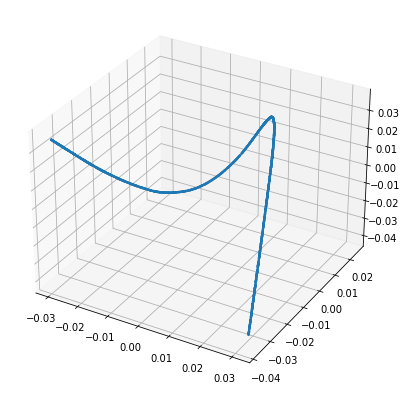

5


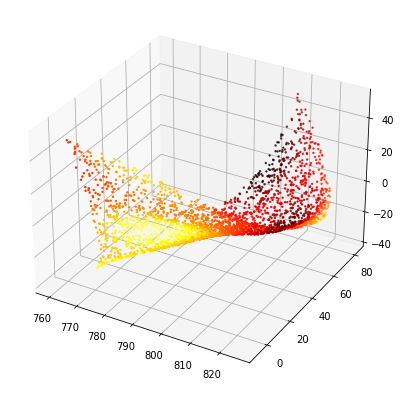

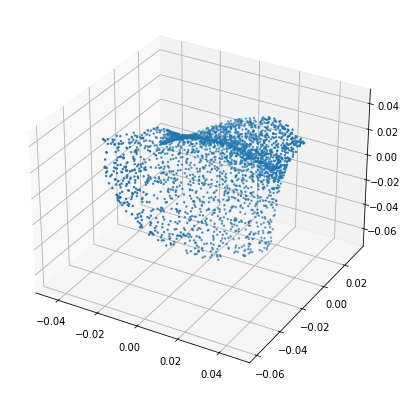

6


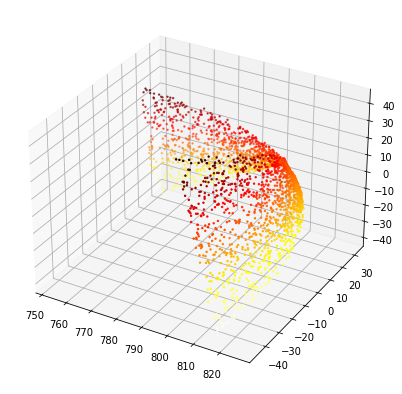

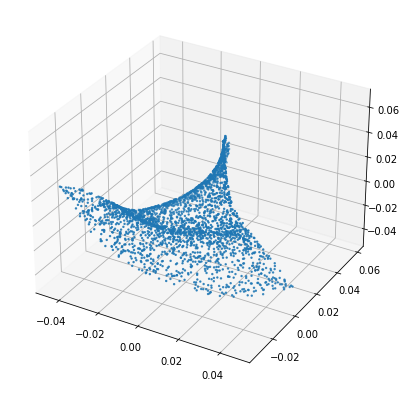

7


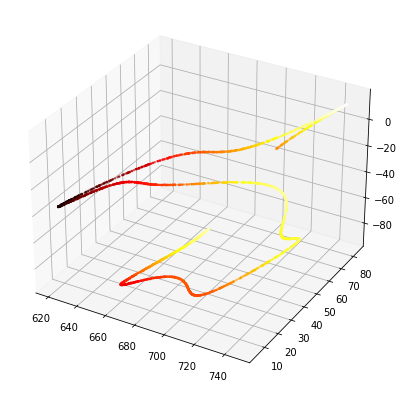

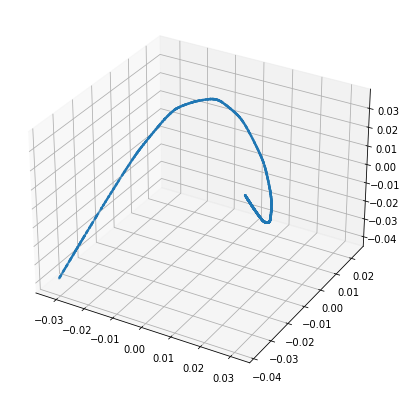

8


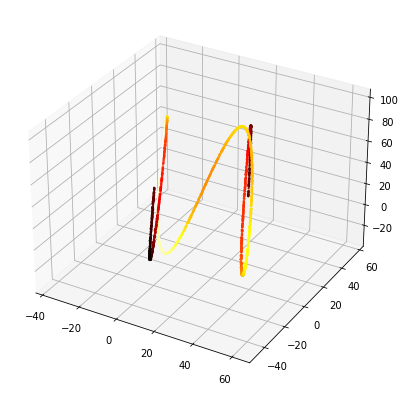

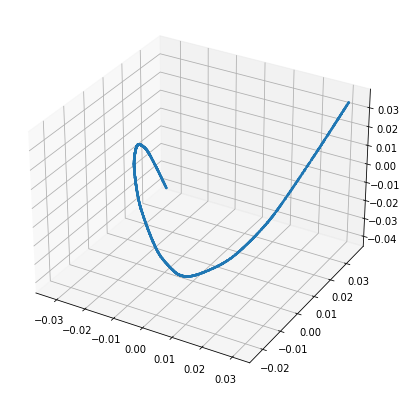

9


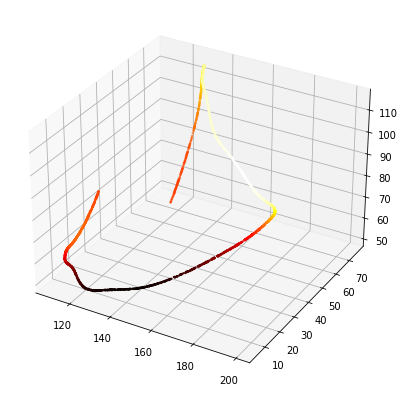

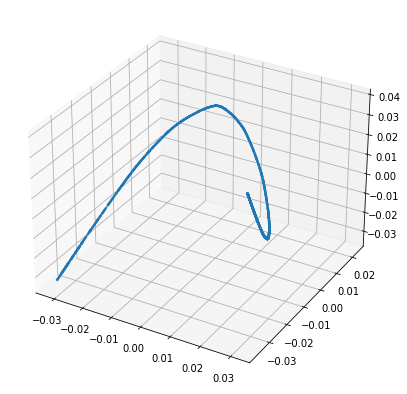

10


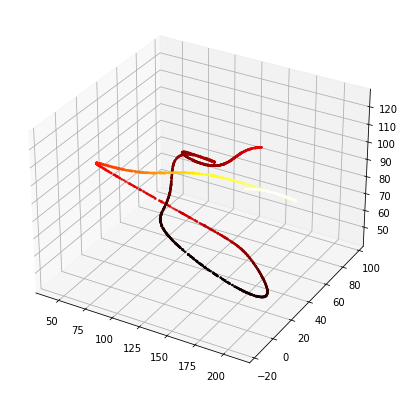

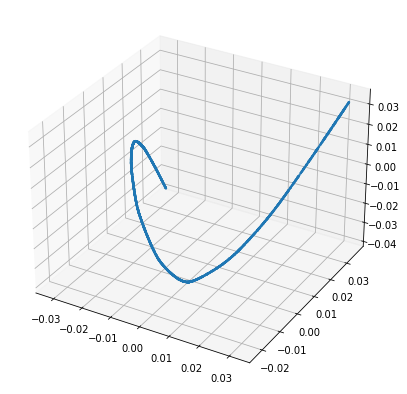

11


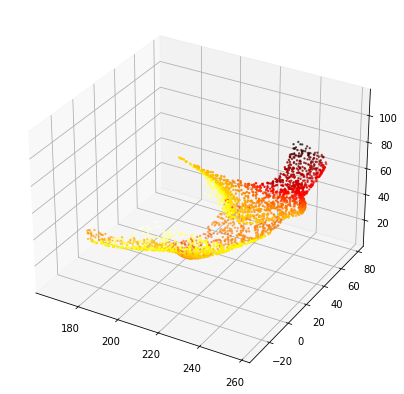

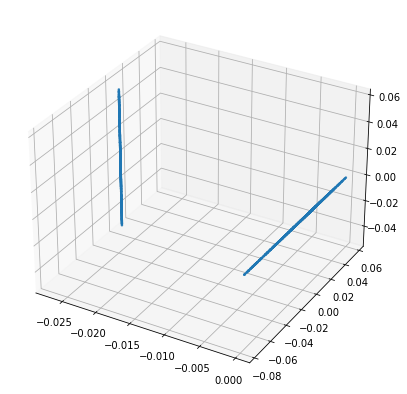

12


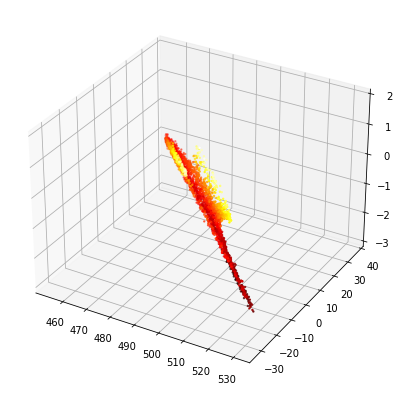

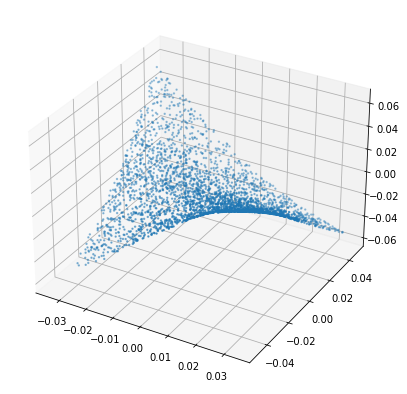

13


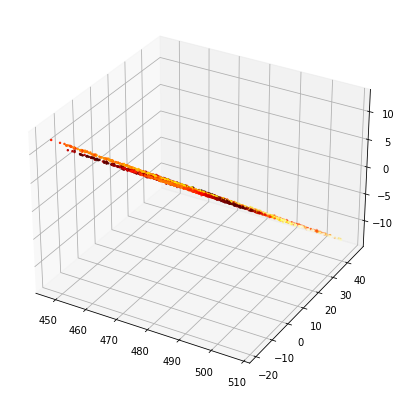

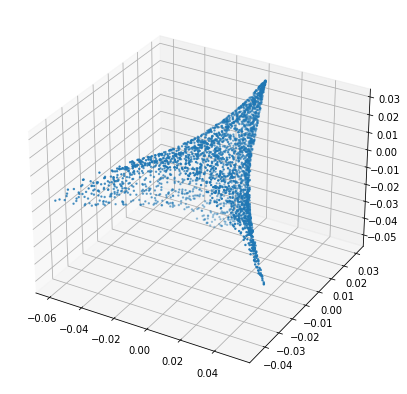

14


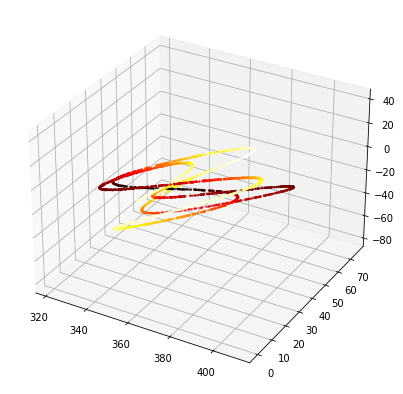

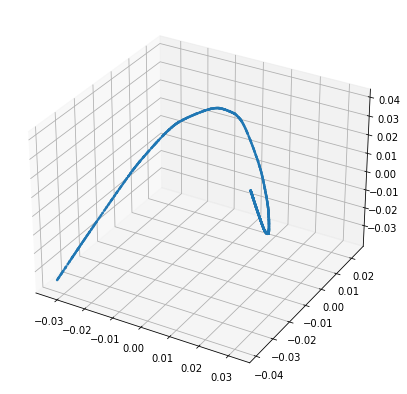

15


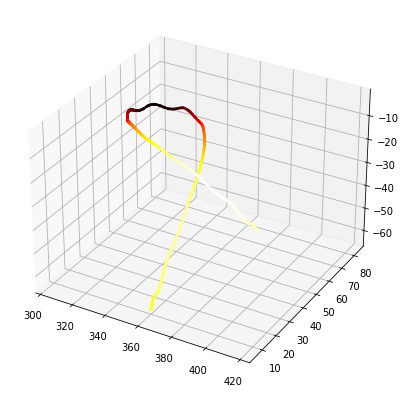

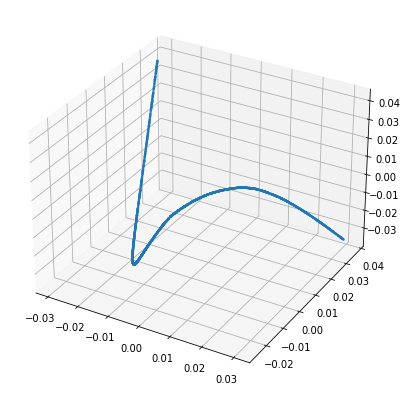

16


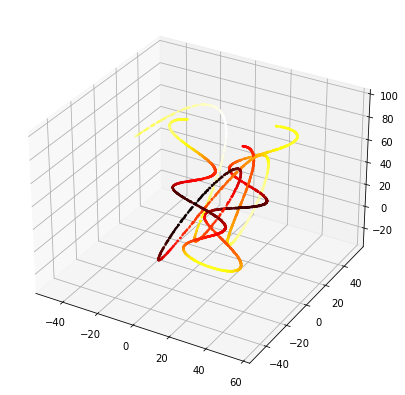

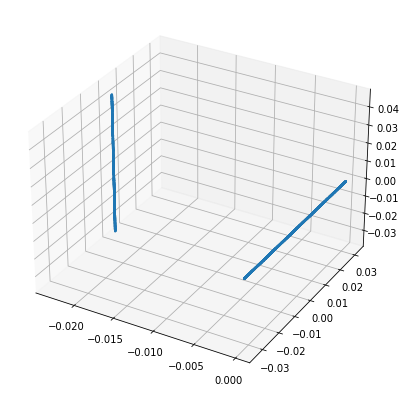

In [6]:
%matplotlib inline
tmp = df.copy()

multi_manifold = [7]

for i in multi_manifold:
  td = 3
  res = pd.DataFrame(LocallyLinearEmbedding(
    n_components=td,
    n_neighbors=20
  ).fit_transform(
    tmp[tmp['manifold'] == i][[j for j in range(d)]]
  ), columns=[i for i in range(td)])
  tmp.loc[tmp['manifold'] == i, 'sub1'] = get_cluster(res, num_cluster=2, cluster_type='HS')
  res['sub1'] = get_cluster(res, num_cluster=2, cluster_type='HS')
tmp['manifold'] = tmp.manifold.astype(str) + '-' + tmp.sub1.astype(str)
tmp.drop(['sub1'], axis=1)
tmp['manifold'] = LabelEncoder().fit_transform(tmp['manifold'])
tmp = merge(tmp, 'manifold', [(1, 9)])  # Merge suitable subsets from last section

df = tmp

for i in range(m):
  print(i)
  td = 3
  res = pd.DataFrame(LocallyLinearEmbedding(
    n_components=td,
    n_neighbors=20
  ).fit_transform(
    tmp[tmp['manifold'] == i][[j for j in range(d)]]
  ), columns=[i for i in range(td)])
  visualize_4d(tmp[(tmp['manifold'] == i)])
  visualize_4d(res)

In [7]:
# custom cluster for manifold
# k3, k2 resulted from visualization with LLE and other reductions
k3 = [16]
k2 = [2, 11]
final_k_list = [1] * m
cluster_type = ['HS'] * m

for t in k2:
  final_k_list[t] = 2
for t in k3:
  final_k_list[t] = 3
for t in k3 + k2:
  cluster_type[t] = 'custom50'
cluster_type[16] = 'custom2d'
print(cluster_type)
print(final_k_list)

['HS', 'HS', 'custom50', 'HS', 'HS', 'HS', 'HS', 'HS', 'HS', 'HS', 'HS', 'custom50', 'HS', 'HS', 'HS', 'HS', 'custom2d']
[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3]


In [ ]:
# Joining the cluster labeling
def join_clusters():
  df['cluster'] = [0] * n
  data_index = [0] * m
  for i in range(n):
    index_manifold = df.at[i,'manifold']
    if index_manifold!=-1:
      df.at[i,'cluster'] = list_labels[index_manifold][data_index[index_manifold]]
      data_index[index_manifold] += 1

list_labels = []
for i in range(m):
  print(i)
  labels = get_cluster(df[df['manifold'] == i][[i for i in range(d)]], num_cluster=final_k_list[i], cluster_type=cluster_type[i])
  list_labels.append(labels)
join_clusters()

In [9]:
%matplotlib inline
def estimate_intrinsic_dimension(data):
  return np.around(np.mean(get_local_intrinsic_dimension(data, n_neighbors=20), axis=0),0).astype(int)

plt.close('all')
D = [1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1]  # Manually checked with visualization
Dp = [estimate_intrinsic_dimension(df[df['manifold'] == i][[j for j in range(d)]]) for i in range(m)]

for i in range(len(D)):
  print(D[i], end=' ')
print()
for i in range(len(D)):
  print(Dp[i], end=' ')

1 1 2 1 1 2 2 1 1 1 1 2 2 2 1 1 1 
1 1 2 1 1 2 2 1 1 1 1 2 2 2 1 1 1 

### Output

In [10]:
# Outputting

vectors = [[[] for j in range(final_k_list[i])] for i in range(m)]
outlier = []
for i in range(n):
  if df.at[i, 'manifold'] == -1:
    outlier.append(i + 1)
  else:
    vectors[df.at[i, 'manifold']][df.at[i, 'cluster']].append(i + 1)

with open('./output.txt', 'w') as f:
  print(f'{n} {m}', file=f)
  for i in range(m):
    dimension = D[i]
    print(f'{dimension} ' + str(final_k_list[i]) + ' Complex', file=f)
    for j in range(0,final_k_list[i]):
      print(str(len(vectors[i][j])) + ' ' + ' '.join(list(map(str, vectors[i][j]))), file=f)
  print(str(len(outlier)) + ' ' + ' '.join(list(map(str, outlier))), file=f)

